## Import thư viện

In [1]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchsummary
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import json
import os
from datasets import load_dataset
import pandas as pd
from PIL import Image

c:\Users\solit\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

In [2]:
class CNN(nn.Module):
    def __init__(self, image_size, out_channels, kernel_size, stride, padding, num_layers=2, num_blocks_per_layer=2, num_classes=100):
        super(CNN, self).__init__()
        self.in_channels = 3
        self.image_size = image_size
        self.layers = self.make_layer(num_layers, num_blocks_per_layer, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, drop_out=0.5)
        self.flatten = nn.Flatten()
        self.image_size = image_size // (2 ** num_layers)
        self.fc = nn.Linear(self.image_size * self.image_size * self.in_channels, num_classes)

    def make_layer(self, num_layers, num_blocks_per_layer, out_channels, kernel_size, stride, padding, drop_out):
        layers = []
        for layer in range(num_layers):
            for block in range(num_blocks_per_layer):
                layers.extend([nn.Conv2d(self.in_channels, out_channels[layer], kernel_size, stride, padding),
                               nn.BatchNorm2d(out_channels[layer]), 
                               nn.ReLU(inplace=True)])
                self.in_channels = out_channels[layer]
            layers.extend([nn.MaxPool2d(kernel_size=2), 
                           nn.Dropout(drop_out)])
        return nn.Sequential(*layers)
            

    def forward(self, x):
        x = self.layers(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [3]:
model = CNN(64, [64, 128, 256], 3, 1, 1, num_layers=3)
torchsummary.summary(model)
x = torch.randn(5, 3, 64, 64)
out = model(x)
out.shape

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
|    └─MaxPool2d: 2-7                    --
|    └─Dropout: 2-8                      --
|    └─Conv2d: 2-9                       73,856
|    └─BatchNorm2d: 2-10                 256
|    └─ReLU: 2-11                        --
|    └─Conv2d: 2-12                      147,584
|    └─BatchNorm2d: 2-13                 256
|    └─ReLU: 2-14                        --
|    └─MaxPool2d: 2-15                   --
|    └─Dropout: 2-16                     --
|    └─Conv2d: 2-17                      295,168
|    └─BatchNorm2d: 2-18                 512
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20                      590,

torch.Size([5, 100])

## TinyImageNet

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Prepare data

In [5]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'train')
        self.classes = sorted(os.listdir(self.image_dir))
        self.images = []
        self.labels = []

        if split == 'train':
            for label_idx, class_dir in enumerate(self.classes):
                class_images = os.listdir(os.path.join(self.image_dir, class_dir, 'images'))
                for img_name in class_images:
                    img_path = os.path.join(self.image_dir, class_dir, 'images', img_name)
                    if self.is_rgb(img_path):
                        self.images.append(os.path.join(class_dir, 'images', img_name))
                        self.labels.append(label_idx)

        elif split == 'val':
            self.image_dir = os.path.join(root_dir, 'val', 'images')
            self.annotations_file = os.path.join(root_dir, 'val', 'val_annotations.txt')
            annotations = pd.read_csv(self.annotations_file, sep='\t', header=None)
            for img_name, label in zip(annotations[0], annotations[1]):
                img_path = os.path.join(self.image_dir, img_name)
                if self.is_rgb(img_path):
                    self.images.append(img_name)
                    self.labels.append(self.classes.index(label))

    def is_rgb(self, img_path):
        with Image.open(img_path) as img:
            return img.mode == 'RGB'

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label


In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(64, padding=4),  
    transforms.RandomHorizontalFlip(),    
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

trainset = TinyImageNetDataset(root_dir='./data/tiny-imagenet-200', split='train', transform=transform_train)
testset = TinyImageNetDataset(root_dir='./data/tiny-imagenet-200', split='val', transform=transform_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


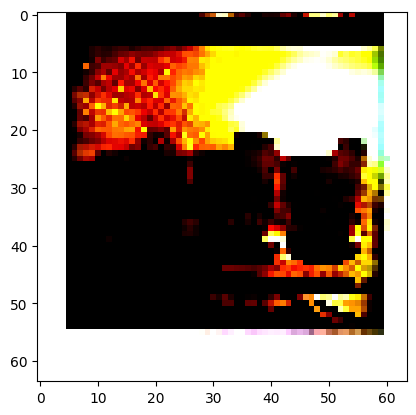

In [7]:
image = testset[2][0].permute(1, 2, 0).numpy()

plt.imshow(image)

In [8]:
print(f'Size: {image.shape}')
print(f'Train: {len(trainset)}')
print(f'Test: {len(testset)}')
print(f'Classes: {len(testset.classes)}')

Size: (64, 64, 3)
Train: 98179
Test: 9832
Classes: 200


### Config

In [9]:
checkpoint_id = 1
folder_path = f'./CNN/TinyImageNet/checkpoint{checkpoint_id}/'
kernel_size = 5
stride = 1
padding = 2
image_size = 64
out_channels = [32, 64]
num_classes = len(trainset.classes)
batch_size = 256
num_epochs = 100
learning_rate = 0.001

os.makedirs(folder_path, exist_ok=True)

config = {
    "checkpoint_id": checkpoint_id,
    "folder_path": folder_path,
    "kernel_size": kernel_size,
    "stride": stride,
    "padding": padding,
    "image_size": image_size,
    "out_channels": out_channels,
    "num_classes": num_classes,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate
}

with open(folder_path + "config.json", "w") as f:
    json.dump(config, f, indent=4)

In [10]:
model = CNN(image_size, out_channels, kernel_size, stride, padding, num_classes=num_classes).to(device)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(trainloader), epochs=num_epochs)
print(model)

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

### Train, test

In [11]:
def train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=10):
    model.train()
    epoch_losses = []
    start = time.time()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() 

            outputs = model(inputs) 
            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step() 

            running_loss += loss.item()
        running_loss = running_loss / len(trainloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
        epoch_losses.append(running_loss)
        scheduler.step()
    end = time.time()
    training_time = (end - start) / 3600

    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.title('Training Loss per Epoch')
    plt.suptitle(f'Training time: {training_time:.2f} hours')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(folder_path + 'training_loss.png')
    plt.show()

    torch.save(model.state_dict(), folder_path + 'model_weights.pth')

def evaluate(model, testloader, device, folder_path):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    correct = sum([1 for a, p in zip(all_labels, all_predictions) if a == p])
    total = len(all_labels)
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.2f}%')
    print("Classification Report:")
    print(report)

    with open(folder_path + 'report.txt', "w") as f:
        f.write(f'Accuracy: {accuracy:.2f}%\n')
        f.write("Classification Report:\n\n")
        f.write(report)
    

  1%|          | 1/100 [01:58<3:15:06, 118.25s/it]

Epoch [1/100], Loss: 5.0177


  2%|▏         | 2/100 [03:59<3:15:44, 119.84s/it]

Epoch [2/100], Loss: 4.4709


  3%|▎         | 3/100 [06:00<3:14:54, 120.57s/it]

Epoch [3/100], Loss: 4.2330


  4%|▍         | 4/100 [08:04<3:14:58, 121.86s/it]

Epoch [4/100], Loss: 4.0353


  5%|▌         | 5/100 [10:07<3:13:42, 122.34s/it]

Epoch [5/100], Loss: 3.8694


  6%|▌         | 6/100 [12:09<3:11:24, 122.18s/it]

Epoch [6/100], Loss: 3.7272


  7%|▋         | 7/100 [14:12<3:09:43, 122.40s/it]

Epoch [7/100], Loss: 3.6183


  8%|▊         | 8/100 [16:15<3:07:53, 122.54s/it]

Epoch [8/100], Loss: 3.5322


  9%|▉         | 9/100 [18:18<3:06:19, 122.85s/it]

Epoch [9/100], Loss: 3.4599


 10%|█         | 10/100 [20:22<3:04:45, 123.18s/it]

Epoch [10/100], Loss: 3.4018


 11%|█         | 11/100 [22:24<3:02:05, 122.76s/it]

Epoch [11/100], Loss: 3.3477


 12%|█▏        | 12/100 [24:26<2:59:30, 122.39s/it]

Epoch [12/100], Loss: 3.3036


 13%|█▎        | 13/100 [26:27<2:56:52, 121.99s/it]

Epoch [13/100], Loss: 3.2608


 14%|█▍        | 14/100 [28:33<2:56:42, 123.29s/it]

Epoch [14/100], Loss: 3.2213


 15%|█▌        | 15/100 [30:35<2:54:16, 123.02s/it]

Epoch [15/100], Loss: 3.1788


 16%|█▌        | 16/100 [32:46<2:55:24, 125.29s/it]

Epoch [16/100], Loss: 3.1511


 17%|█▋        | 17/100 [34:52<2:53:32, 125.46s/it]

Epoch [17/100], Loss: 3.1152


 18%|█▊        | 18/100 [36:55<2:50:42, 124.91s/it]

Epoch [18/100], Loss: 3.0807


 19%|█▉        | 19/100 [38:59<2:48:01, 124.46s/it]

Epoch [19/100], Loss: 3.0526


 20%|██        | 20/100 [41:01<2:45:15, 123.94s/it]

Epoch [20/100], Loss: 3.0253


 21%|██        | 21/100 [43:04<2:42:37, 123.51s/it]

Epoch [21/100], Loss: 3.0007


 22%|██▏       | 22/100 [45:06<2:39:58, 123.05s/it]

Epoch [22/100], Loss: 2.9752


 23%|██▎       | 23/100 [47:06<2:36:53, 122.25s/it]

Epoch [23/100], Loss: 2.9488


 24%|██▍       | 24/100 [49:07<2:34:11, 121.72s/it]

Epoch [24/100], Loss: 2.9307


 25%|██▌       | 25/100 [51:07<2:31:38, 121.31s/it]

Epoch [25/100], Loss: 2.9124


 26%|██▌       | 26/100 [53:10<2:30:02, 121.65s/it]

Epoch [26/100], Loss: 2.8875


 27%|██▋       | 27/100 [55:15<2:29:20, 122.75s/it]

Epoch [27/100], Loss: 2.8693


 28%|██▊       | 28/100 [57:19<2:27:56, 123.28s/it]

Epoch [28/100], Loss: 2.8509


 29%|██▉       | 29/100 [59:22<2:25:27, 122.92s/it]

Epoch [29/100], Loss: 2.8355


 30%|███       | 30/100 [1:01:24<2:23:05, 122.65s/it]

Epoch [30/100], Loss: 2.8148


 31%|███       | 31/100 [1:03:25<2:20:46, 122.42s/it]

Epoch [31/100], Loss: 2.8011


 32%|███▏      | 32/100 [1:05:28<2:18:51, 122.53s/it]

Epoch [32/100], Loss: 2.7800


 33%|███▎      | 33/100 [1:07:30<2:16:41, 122.40s/it]

Epoch [33/100], Loss: 2.7635


 34%|███▍      | 34/100 [1:09:32<2:14:16, 122.08s/it]

Epoch [34/100], Loss: 2.7523


 35%|███▌      | 35/100 [1:11:34<2:12:26, 122.25s/it]

Epoch [35/100], Loss: 2.7337


 36%|███▌      | 36/100 [1:13:34<2:09:41, 121.58s/it]

Epoch [36/100], Loss: 2.7215


 37%|███▋      | 37/100 [1:15:33<2:06:42, 120.68s/it]

Epoch [37/100], Loss: 2.7067


 38%|███▊      | 38/100 [1:17:35<2:05:10, 121.13s/it]

Epoch [38/100], Loss: 2.6955


 39%|███▉      | 39/100 [1:19:35<2:02:47, 120.78s/it]

Epoch [39/100], Loss: 2.6880


 40%|████      | 40/100 [1:21:37<2:01:03, 121.05s/it]

Epoch [40/100], Loss: 2.6711


 41%|████      | 41/100 [1:23:39<1:59:14, 121.27s/it]

Epoch [41/100], Loss: 2.6606


 42%|████▏     | 42/100 [1:25:40<1:57:21, 121.40s/it]

Epoch [42/100], Loss: 2.6478


 43%|████▎     | 43/100 [1:27:41<1:55:15, 121.32s/it]

Epoch [43/100], Loss: 2.6365


 44%|████▍     | 44/100 [1:29:44<1:53:32, 121.64s/it]

Epoch [44/100], Loss: 2.6276


 45%|████▌     | 45/100 [1:31:48<1:52:20, 122.55s/it]

Epoch [45/100], Loss: 2.6158


 46%|████▌     | 46/100 [1:33:50<1:49:56, 122.16s/it]

Epoch [46/100], Loss: 2.6056


 47%|████▋     | 47/100 [1:35:53<1:48:11, 122.47s/it]

Epoch [47/100], Loss: 2.5907


 48%|████▊     | 48/100 [1:37:55<1:45:56, 122.24s/it]

Epoch [48/100], Loss: 2.5817


 49%|████▉     | 49/100 [1:40:00<1:44:49, 123.33s/it]

Epoch [49/100], Loss: 2.5769


 50%|█████     | 50/100 [1:42:08<1:43:47, 124.55s/it]

Epoch [50/100], Loss: 2.5622


 51%|█████     | 51/100 [1:44:09<1:40:46, 123.39s/it]

Epoch [51/100], Loss: 2.5601


 52%|█████▏    | 52/100 [1:46:11<1:38:23, 122.98s/it]

Epoch [52/100], Loss: 2.5478


 53%|█████▎    | 53/100 [1:48:15<1:36:39, 123.39s/it]

Epoch [53/100], Loss: 2.5406


 54%|█████▍    | 54/100 [1:50:20<1:34:58, 123.89s/it]

Epoch [54/100], Loss: 2.5307


 55%|█████▌    | 55/100 [1:52:24<1:33:02, 124.06s/it]

Epoch [55/100], Loss: 2.5229


 56%|█████▌    | 56/100 [1:54:30<1:31:14, 124.43s/it]

Epoch [56/100], Loss: 2.5155


 57%|█████▋    | 57/100 [1:56:34<1:29:05, 124.31s/it]

Epoch [57/100], Loss: 2.5079


 58%|█████▊    | 58/100 [1:58:38<1:26:57, 124.23s/it]

Epoch [58/100], Loss: 2.4989


 59%|█████▉    | 59/100 [2:00:41<1:24:36, 123.81s/it]

Epoch [59/100], Loss: 2.4910


 60%|██████    | 60/100 [2:02:41<1:21:51, 122.79s/it]

Epoch [60/100], Loss: 2.4793


 61%|██████    | 61/100 [2:04:44<1:19:48, 122.78s/it]

Epoch [61/100], Loss: 2.4786


 62%|██████▏   | 62/100 [2:06:47<1:17:54, 123.02s/it]

Epoch [62/100], Loss: 2.4703


 63%|██████▎   | 63/100 [2:08:48<1:15:28, 122.40s/it]

Epoch [63/100], Loss: 2.4571


 64%|██████▍   | 64/100 [2:10:48<1:12:58, 121.63s/it]

Epoch [64/100], Loss: 2.4527


 65%|██████▌   | 65/100 [2:12:49<1:10:48, 121.40s/it]

Epoch [65/100], Loss: 2.4486


 66%|██████▌   | 66/100 [2:14:52<1:09:01, 121.81s/it]

Epoch [66/100], Loss: 2.4440


 67%|██████▋   | 67/100 [2:16:55<1:07:12, 122.20s/it]

Epoch [67/100], Loss: 2.4354


 68%|██████▊   | 68/100 [2:18:56<1:04:58, 121.82s/it]

Epoch [68/100], Loss: 2.4326


 69%|██████▉   | 69/100 [2:20:58<1:03:00, 121.95s/it]

Epoch [69/100], Loss: 2.4216


 70%|███████   | 70/100 [2:23:03<1:01:25, 122.87s/it]

Epoch [70/100], Loss: 2.4135


 71%|███████   | 71/100 [2:25:08<59:43, 123.58s/it]  

Epoch [71/100], Loss: 2.4064


 72%|███████▏  | 72/100 [2:27:08<57:08, 122.46s/it]

Epoch [72/100], Loss: 2.4050


 73%|███████▎  | 73/100 [2:29:09<54:50, 121.88s/it]

Epoch [73/100], Loss: 2.3979


 74%|███████▍  | 74/100 [2:31:13<53:07, 122.61s/it]

Epoch [74/100], Loss: 2.3941


 75%|███████▌  | 75/100 [2:33:14<50:54, 122.20s/it]

Epoch [75/100], Loss: 2.3888


 76%|███████▌  | 76/100 [2:35:14<48:38, 121.59s/it]

Epoch [76/100], Loss: 2.3861


 77%|███████▋  | 77/100 [2:37:16<46:35, 121.54s/it]

Epoch [77/100], Loss: 2.3745


 78%|███████▊  | 78/100 [2:39:16<44:23, 121.08s/it]

Epoch [78/100], Loss: 2.3700


 79%|███████▉  | 79/100 [2:41:16<42:19, 120.93s/it]

Epoch [79/100], Loss: 2.3642


 80%|████████  | 80/100 [2:43:20<40:33, 121.66s/it]

Epoch [80/100], Loss: 2.3622


 81%|████████  | 81/100 [2:45:23<38:42, 122.22s/it]

Epoch [81/100], Loss: 2.3521


 82%|████████▏ | 82/100 [2:47:27<36:50, 122.81s/it]

Epoch [82/100], Loss: 2.3518


 83%|████████▎ | 83/100 [2:49:28<34:34, 122.02s/it]

Epoch [83/100], Loss: 2.3447


 84%|████████▍ | 84/100 [2:51:28<32:23, 121.48s/it]

Epoch [84/100], Loss: 2.3428


 85%|████████▌ | 85/100 [2:53:30<30:26, 121.76s/it]

Epoch [85/100], Loss: 2.3374


 86%|████████▌ | 86/100 [2:55:31<28:21, 121.54s/it]

Epoch [86/100], Loss: 2.3252


 87%|████████▋ | 87/100 [2:57:34<26:24, 121.87s/it]

Epoch [87/100], Loss: 2.3260


 88%|████████▊ | 88/100 [2:59:36<24:22, 121.91s/it]

Epoch [88/100], Loss: 2.3253


 89%|████████▉ | 89/100 [3:01:39<22:25, 122.33s/it]

Epoch [89/100], Loss: 2.3165


 90%|█████████ | 90/100 [3:03:42<20:25, 122.51s/it]

Epoch [90/100], Loss: 2.3096


 91%|█████████ | 91/100 [3:05:43<18:17, 121.91s/it]

Epoch [91/100], Loss: 2.3067


 92%|█████████▏| 92/100 [3:07:44<16:13, 121.72s/it]

Epoch [92/100], Loss: 2.3070


 93%|█████████▎| 93/100 [3:09:45<14:11, 121.59s/it]

Epoch [93/100], Loss: 2.3039


 94%|█████████▍| 94/100 [3:11:46<12:07, 121.22s/it]

Epoch [94/100], Loss: 2.2995


 95%|█████████▌| 95/100 [3:13:46<10:04, 120.94s/it]

Epoch [95/100], Loss: 2.2946


 96%|█████████▌| 96/100 [3:15:48<08:04, 121.16s/it]

Epoch [96/100], Loss: 2.2892


 97%|█████████▋| 97/100 [3:17:50<06:04, 121.43s/it]

Epoch [97/100], Loss: 2.2842


 98%|█████████▊| 98/100 [3:19:53<04:03, 121.97s/it]

Epoch [98/100], Loss: 2.2805


 99%|█████████▉| 99/100 [3:21:54<02:01, 121.66s/it]

Epoch [99/100], Loss: 2.2754


100%|██████████| 100/100 [3:23:56<00:00, 122.36s/it]

Epoch [100/100], Loss: 2.2760


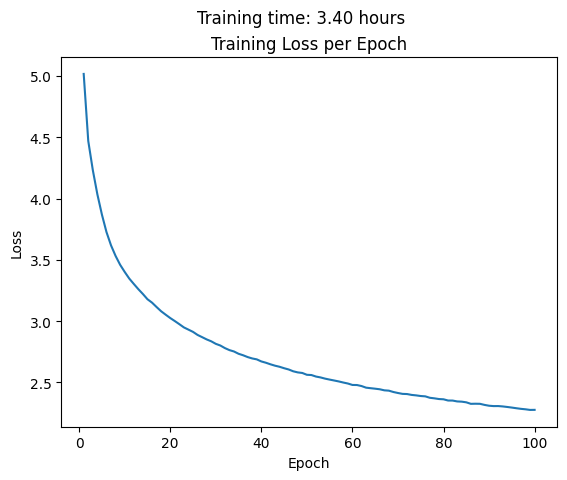

In [12]:
train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=num_epochs)

In [13]:
evaluate(model, testloader, device, folder_path)

Accuracy: 36.82%
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.70      0.61        50
           1       0.53      0.72      0.61        50
           2       0.29      0.52      0.37        50
           3       0.23      0.38      0.29        50
           4       0.27      0.61      0.37        49
           5       0.04      0.06      0.05        50
           6       0.33      0.64      0.44        50
           7       0.43      0.20      0.27        50
           8       0.54      0.60      0.57        50
           9       0.20      0.40      0.27        50
          10       0.20      0.12      0.15        50
          11       0.37      0.40      0.38        47
          12       0.44      0.64      0.52        50
          13       0.61      0.62      0.61        50
          14       0.37      0.46      0.41        50
          15       0.36      0.20      0.26        49
          16       0.14      0.16      0.